In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from lib.data.datasets import AccRawDataset
from lib.data.dataloading import load_raw
from lib.config import RAW_DIR
from lib.modules import optimization_loop_xonly
from lib.models import MAEAlpha, MAEBeta, MAEGamma, MAEDelta

In [32]:
WINSIZE = 1001
trainloader, testloader = load_raw(
    RAW_DIR,
    WINSIZE,
    n_hours=0.5,
    sessions=['2023-11-02_13_55_22'],
    test_size=0.5,
    batch_size=128,
    shuffle_test=True,
    chunk_len_hrs=0.01
)

Using Directories: ['2023-11-02_13_55_22']
Index: 0, Date: 2023-11-02_13_55_22, nSamples: 2499818, Time Elapsed: 13:04:33.095864, Time Recorded: 6:56:38.180000
Created 694 chunks of length 3600 samples each
Randomly selected 50 chunks
Total train length: 0:19:10 (115000 Samples)
Total test length: 0:19:10 (115000 Samples)


In [7]:
DEVICE = 'cuda:1'
model = MAEDelta(WINSIZE, 3).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
sum([p.numel() for p in model.parameters()])

4155075

In [ ]:
optimization_loop_xonly(
    model,
    trainloader,
    testloader,
    criterion,
    optimizer,
    epochs=20,
    device=DEVICE,
    outdir='dev/7_mae/dev'
)

In [8]:
model.load_state_dict(torch.load('dev/8_mae/delta_mask75/best_model.pt'))

<All keys matched successfully>

In [10]:
import plotly.express as px
import pandas as pd

for X in trainloader:
    x = X.view(-1, 3, WINSIZE).to(DEVICE)
    logits = model(x).detach().cpu()
    break

In [26]:
i = slice(10,30)
df = pd.DataFrame({
    'x': X[i,:1001].flatten(), 
    'y': X[i,1001:2002].flatten(), 
    'z': X[i,2002:].flatten(), 
    'x_pred': logits[i,:1001].flatten(), 
    'y_pred': logits[i,1001:2002].flatten(), 
    'z_pred': logits[i,2002:].flatten(),
})
fig = px.line(df, x=df.index, y=['x', 'x_pred', 'y', 'y_pred', 'z', 'z_pred'])
fig.show(renderer='browser')

In [67]:
import matplotlib.pyplot as plt

embedding = []
Xs = []
embedding_c = []
for i,X in enumerate(tqdm(trainloader)):
    with torch.no_grad():
        Xs.append(X)
        X = X.view(-1, 3, WINSIZE)
        X = X.to(DEVICE)
        x = model.e(X)
        embedding.append(x.detach().cpu().mean(dim=2))
        x = model.transformer_encoder(x)
        embedding_c.append(x.detach().cpu().mean(dim=2))
    
    if i == 100:
        break

embedding = torch.cat(embedding, dim=0)
Xs = torch.cat(Xs, dim=0)
embedding_c = torch.cat(embedding_c, dim=0)

  0%|          | 0/891 [00:00<?, ?it/s]

 11%|█         | 100/891 [00:16<02:10,  6.06it/s]


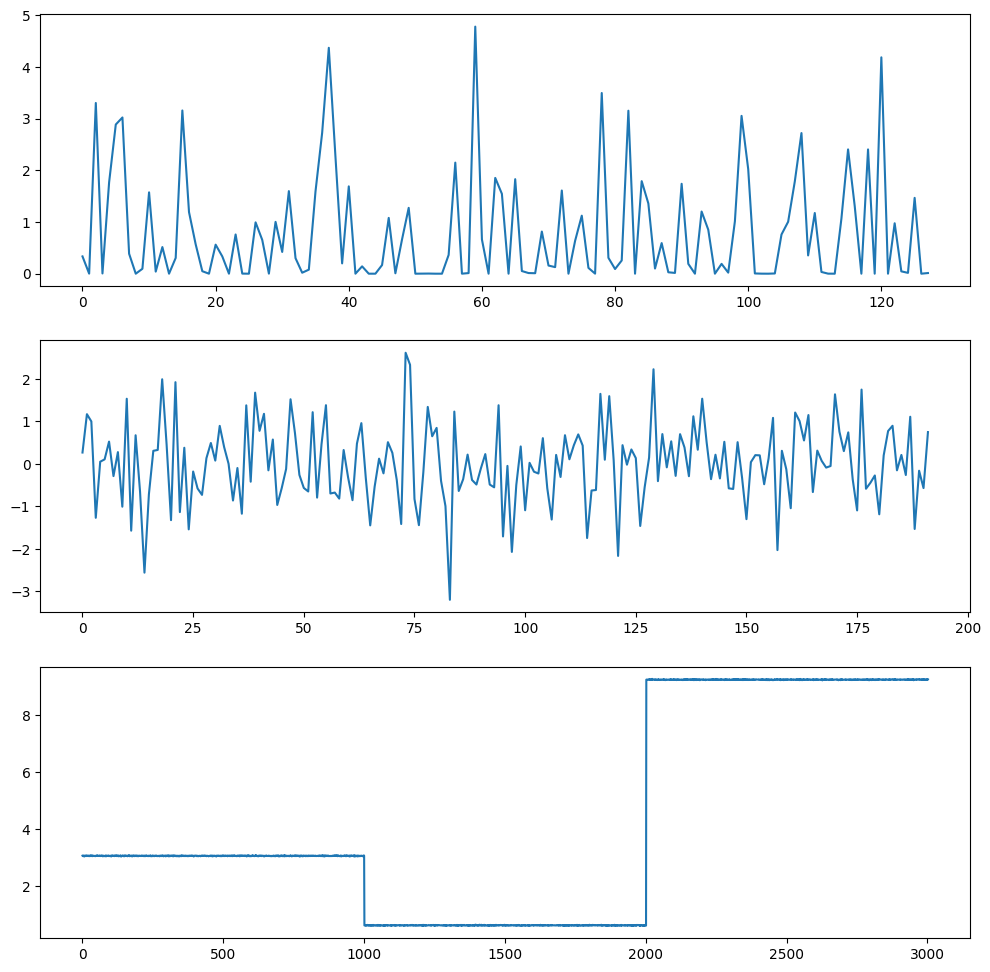

In [63]:
i = 100
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
axs[0].plot(embedding[i])
axs[1].plot(embedding_c[i])
axs[2].plot(Xs[i])
plt.show()

/home/musa/eating/eating-detection/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



WSS: 30702.62109375
Var explained: [0.75015883 0.13529889 0.07273977 0.03219448]
Total variance captured: 0.9903919782154151


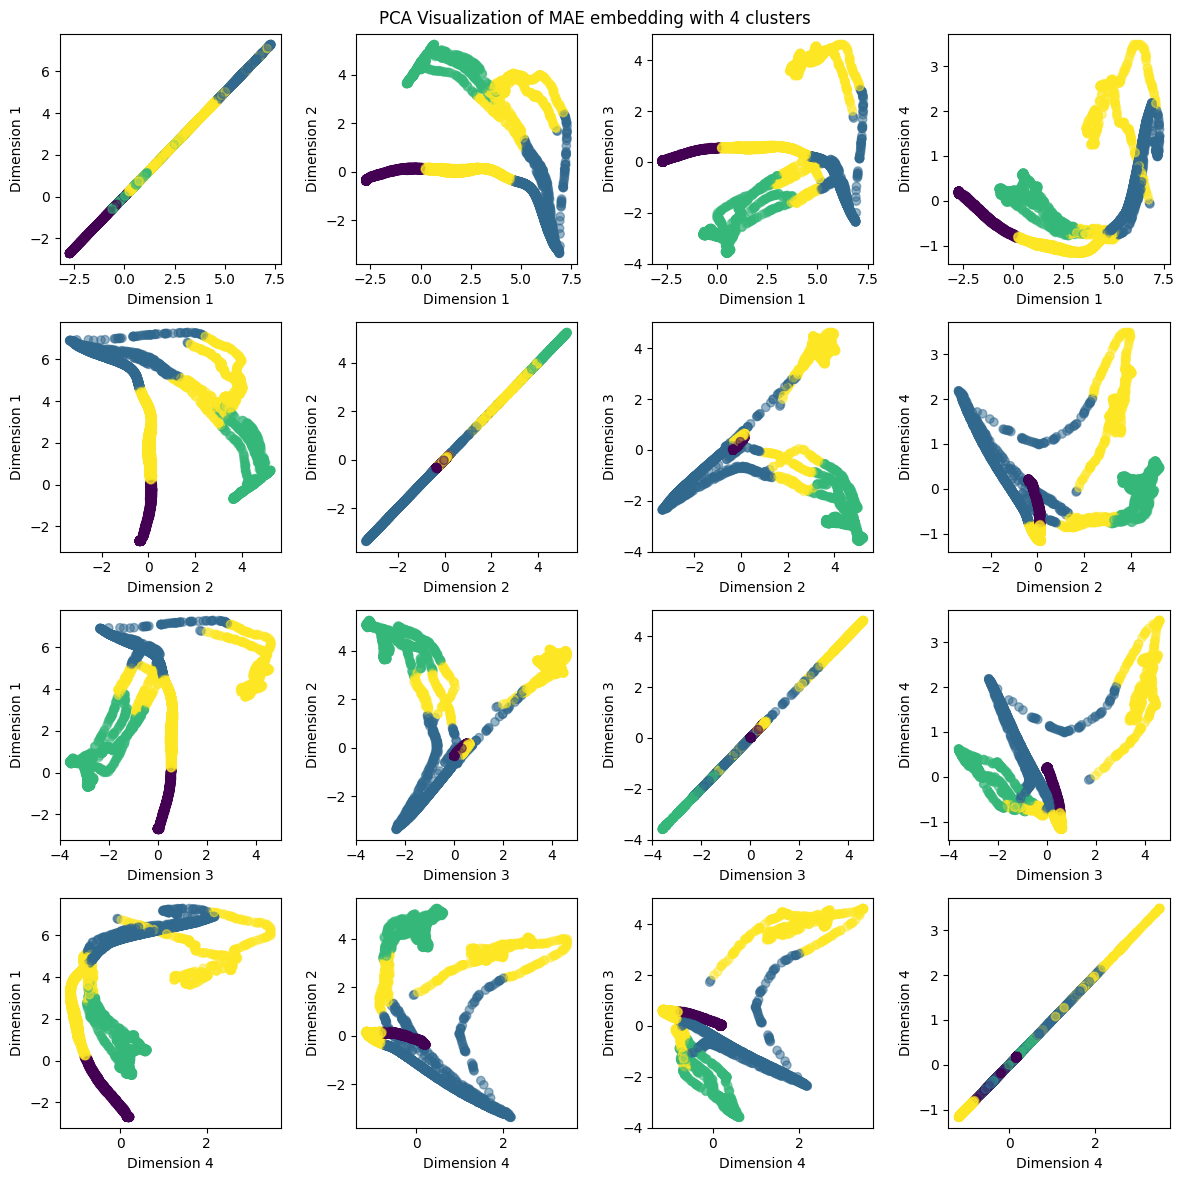

In [70]:
# plot the embedding with 4 components and clusters
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

emb_np = embedding.numpy()

# Cluster each sample (1001 dims) into one of 4 clusters
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(emb_np)

print(f'WSS: {kmeans.inertia_}')

# four components
n_comp = 4
pca = PCA(n_components=n_comp)
data_pca = pca.fit_transform(embedding)

print(f'Var explained: {pca.explained_variance_ratio_}')
print(f'Total variance captured: {sum(pca.explained_variance_ratio_)}')

fig, axs = plt.subplots(n_comp, n_comp, figsize=(12, 12))
fig.suptitle('PCA Visualization of MAE embedding with 4 clusters')

for i in range(n_comp):
    for j in range(n_comp):
        axs[i, j].scatter(data_pca[:, i], data_pca[:, j], alpha=0.5, c=cluster_labels, cmap='viridis')
        axs[i, j].set_xlabel(f'Dimension {i + 1}')
        axs[i, j].set_ylabel(f'Dimension {j + 1}')

plt.tight_layout()
plt.show()

/home/musa/eating/eating-detection/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



WSS: 51280.99609375
Var explained: [0.78723166 0.10349524 0.06414615 0.02215801]
Total variance captured: 0.977031063403047


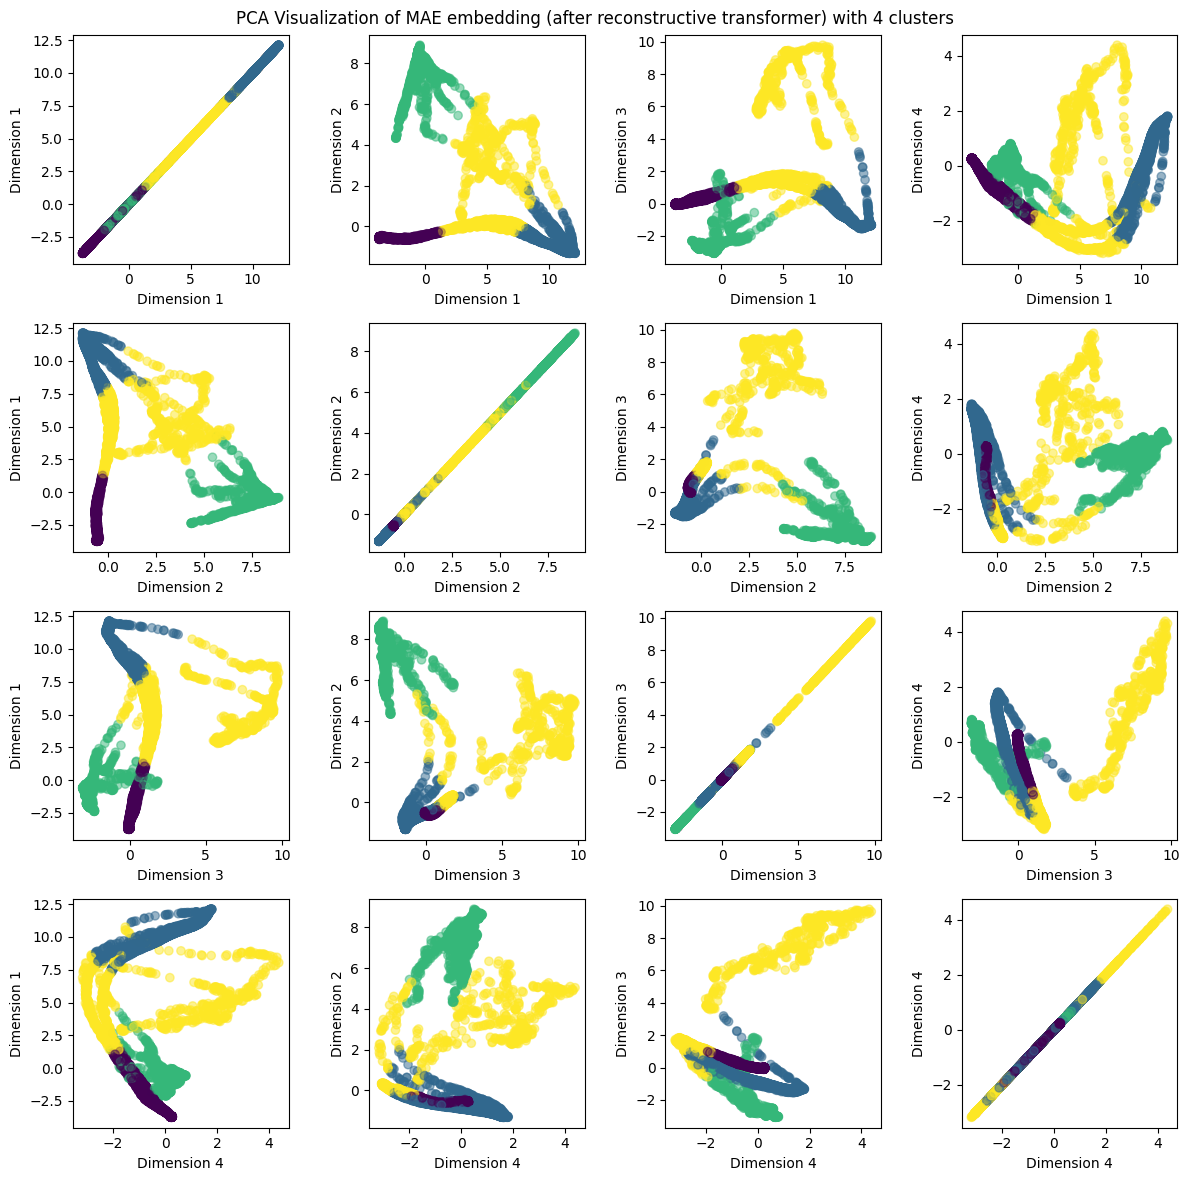

In [71]:
# plot the embedding after transformer with 4 components and clusters
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

embc_np = embedding_c.numpy()

# Cluster each sample (1001 dims) into one of 4 clusters
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(embc_np)

print(f'WSS: {kmeans.inertia_}')

# four components
n_comp = 4
pca = PCA(n_components=n_comp)
data_pca = pca.fit_transform(embedding_c)

print(f'Var explained: {pca.explained_variance_ratio_}')
print(f'Total variance captured: {sum(pca.explained_variance_ratio_)}')

fig, axs = plt.subplots(n_comp, n_comp, figsize=(12, 12))
fig.suptitle('PCA Visualization of MAE embedding (after reconstructive transformer) with 4 clusters')

for i in range(n_comp):
    for j in range(n_comp):
        axs[i, j].scatter(data_pca[:, i], data_pca[:, j], alpha=0.5, c=cluster_labels, cmap='viridis')
        axs[i, j].set_xlabel(f'Dimension {i + 1}')
        axs[i, j].set_ylabel(f'Dimension {j + 1}')

plt.tight_layout()
plt.show()

/home/musa/eating/eating-detection/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



WSS: 111058184.0
Var explained: [0.47622028 0.18944435 0.06095913 0.05172031]
Total variance captured: 0.7783440686762333


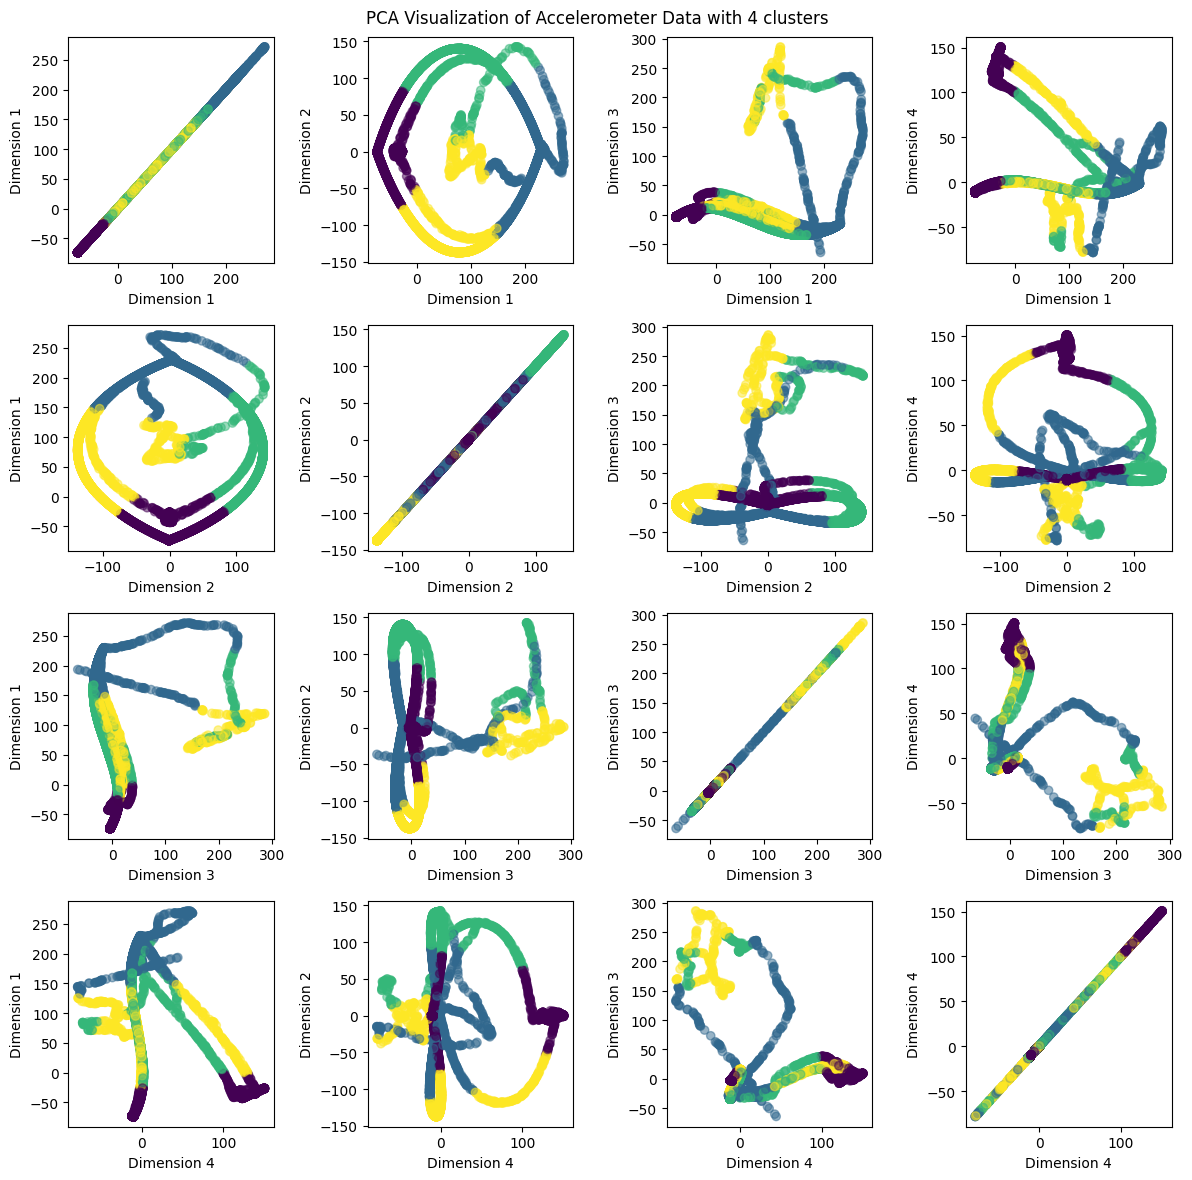

In [72]:
# plot the acc data with 4 components and clusters
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Xs_np = Xs.numpy()

# Cluster each sample (3003 dims) into one of 4 clusters
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(Xs_np)
print(f'WSS: {kmeans.inertia_}')

# Apply PCA for dimensionality reduction to 2 components
pca = PCA(n_components=4)
data_pca = pca.fit_transform(Xs_np)
print(f'Var explained: {pca.explained_variance_ratio_}')
print(f'Total variance captured: {sum(pca.explained_variance_ratio_)}')

fig, axs = plt.subplots(n_comp, n_comp, figsize=(12, 12))
fig.suptitle('PCA Visualization of Accelerometer Data with 4 clusters')

for i in range(n_comp):
    for j in range(n_comp):
        axs[i, j].scatter(data_pca[:, i], data_pca[:, j], alpha=0.5, c=cluster_labels, cmap='viridis')
        axs[i, j].set_xlabel(f'Dimension {i + 1}')
        axs[i, j].set_ylabel(f'Dimension {j + 1}')

fig.tight_layout()
plt.show()

In [ ]:
# plot embeddings with 2 components
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

emb_np = embedding.numpy()

# Cluster each sample (1001 dims) into one of 4 clusters
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(emb_np)

# Apply PCA for dimensionality reduction to 2 components
pca = PCA(n_components=2)
data_pca = pca.fit_transform(emb_np)

# Visualize the reduced data using a scatter plot
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('PCA Visualization of MAE embedding with 4 clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
# plot accelerometer data with 2 components
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Xs_np = Xs.numpy()

# Cluster each sample (3003 dims) into one of 4 clusters
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(Xs_np)
print(f'WSS: {kmeans.inertia_}')

# Apply PCA for dimensionality reduction to 2 components
pca = PCA(n_components=2)
data_pca = pca.fit_transform(Xs_np)
print(f'Var explained: {pca.explained_variance_ratio_}')
print(f'Total variance captured: {sum(pca.explained_variance_ratio_)}')

# Visualize the reduced data using a scatter plot
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('PCA Visualization of Accelerometer Data with 4 clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
